In [90]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import random
random.seed(56)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
plt.style.use('fivethirtyeight')
plt.rc("font", family="Malgun Gothic")
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
from datetime import datetime as dt
from sklearn.model_selection import StratifiedKFold

import lightgbm
import optuna
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

## Dataset

In [65]:
# 학습 데이터
train = pd.read_csv('./train.csv')
train

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,TRAIN_593,1,0.526546,2022-09-08 14:30,T100306,T_31,2.0,95.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
594,TRAIN_594,0,0.524022,2022-09-08 22:38,T050304,A_31,NaN,NaN,NaN,NaN,...,49.47,53.07,50.89,55.10,66.49,1.0,NaN,NaN,NaN,NaN
595,TRAIN_595,0,0.521289,2022-09-08 22:47,T050304,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
596,TRAIN_596,1,0.531375,2022-09-08 14:38,T100304,O_31,40.0,94.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* PRODUCT_ID : 제품의 고유 ID
* Y_Class : 제품 품질 상태(Target) (0 : 기준 미달, 1 : 적합, 2 : 기준 초과)
* Y_Quality : 제품 품질 수치
* TIMESTAMP : 제품이 공정에 들어간 시각
* LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
* PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
* X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수

In [66]:
# 검증 데이터
test = pd.read_csv('./test.csv')
test.head()

,PRODUCT_ID,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TEST_000,2022-09-09 2:01,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TEST_001,2022-09-09 2:09,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TEST_002,2022-09-09 8:42,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TEST_003,2022-09-09 10:56,T010305,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TEST_004,2022-09-09 11:04,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* PRODUCT_ID : 제품의 고유 ID
* TIMESTAMP : 제품이 공정에 들어간 시각
* LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
* PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
* X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수

In [67]:
# 제출 양식
subm = pd.read_csv('./sample_submission.csv')
subm.head()

,PRODUCT_ID,Y_Class
0,TEST_000,0
1,TEST_001,0
2,TEST_002,0
3,TEST_003,0
4,TEST_004,0


* PRODUCT_ID : 제품의 고유 ID
* Y_Class : 예측한 제품 품질 상태 (0 : 기준 미달, 1 : 적합, 2 : 기준 초과)

### dtypes

In [68]:
train.dtypes

PRODUCT_ID     object
Y_Class         int64
Y_Quality     float64
TIMESTAMP      object
LINE           object
               ...   
X_2871        float64
X_2872        float64
X_2873        float64
X_2874        float64
X_2875        float64
Length: 2881, dtype: object

In [69]:
train['LINE'] = train['LINE'].astype('category')
train['PRODUCT_CODE'] = train['PRODUCT_CODE'].astype('category')

### Y Class & Y Quality

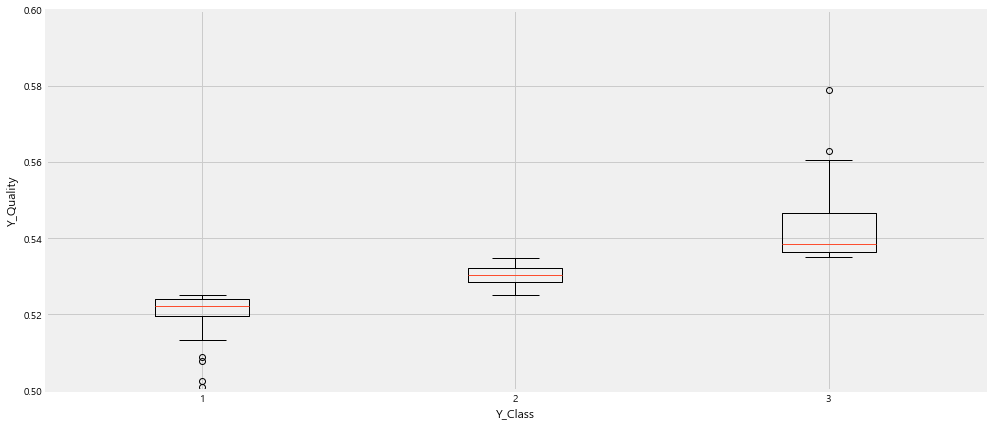

In [70]:
rcParams['figure.figsize'] = 15, 7

fig, ax = plt.subplots()

ax.boxplot([train[train['Y_Class']==0].Y_Quality, train[train['Y_Class']==1].Y_Quality, train[train['Y_Class']==2].Y_Quality])
ax.set_ylim(0.5, 0.6)
ax.set_xlabel('Y_Class')
ax.set_ylabel('Y_Quality')
plt.show()

In [71]:
# Class는 Quality를 3등분한 결과
for i in range(3):
    tmp = train[train['Y_Class']==i].Y_Quality
    print(f'Class : {i}, Quality range : {min(tmp)} ~ {max(tmp)}')

Class : 0, Quality range : 0.500855556 ~ 0.525066667
Class : 1, Quality range : 0.525085714 ~ 0.534842857
Class : 2, Quality range : 0.534950794 ~ 0.57884127


In [72]:
train.Y_Class.value_counts()

1    407
2    103
0     88
Name: Y_Class, dtype: int64

### Product Code

In [73]:
# Product Code는 3가지로 이루어져 있다.
train['PRODUCT_CODE'].value_counts()

T_31    343
A_31    249
O_31      6
Name: PRODUCT_CODE, dtype: int64

### Line

In [74]:
# Line은 6가지
train['LINE'].value_counts()

T100304    175
T100306    174
T050304     78
T010306     70
T010305     59
T050307     42
Name: LINE, dtype: int64

### TimeStamp

* 일, 시, 분 단위 모두 연속적이지 않으므로 활용할 수 없다. interpolate(보간)을 하기에도 너무 공백이 많다.
* 단 월 단위는 quality의 감소세가 확인된다.

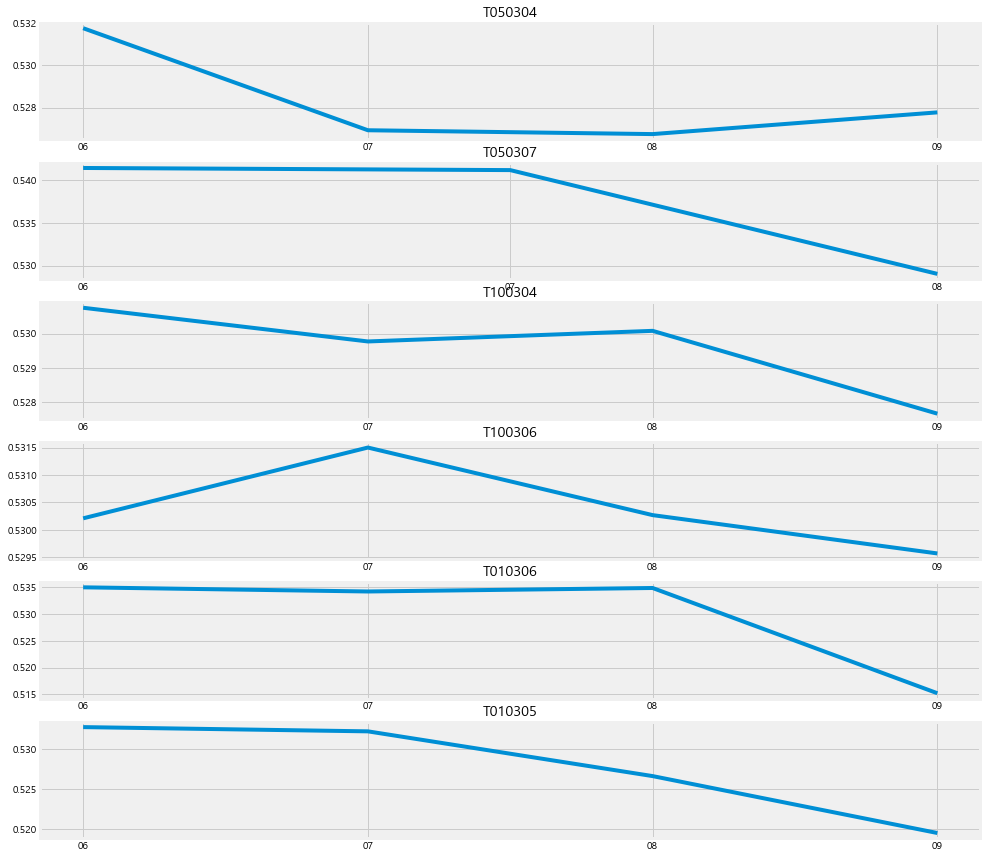

In [75]:
# LINE
rcParams['figure.figsize'] = 15, 15

for i, l in enumerate(train.LINE.unique()):
    plt.subplot(len(train.LINE.unique()), 1, i+1)
    tmp = train[train['LINE']==l]
    tmp['TIMESTAMP'] = pd.to_datetime(tmp['TIMESTAMP']).dt.strftime('%m')
    tmp = tmp.groupby('TIMESTAMP').mean()
    plt.plot(tmp.index, tmp['Y_Quality'])
    plt.title(l)
plt.show()

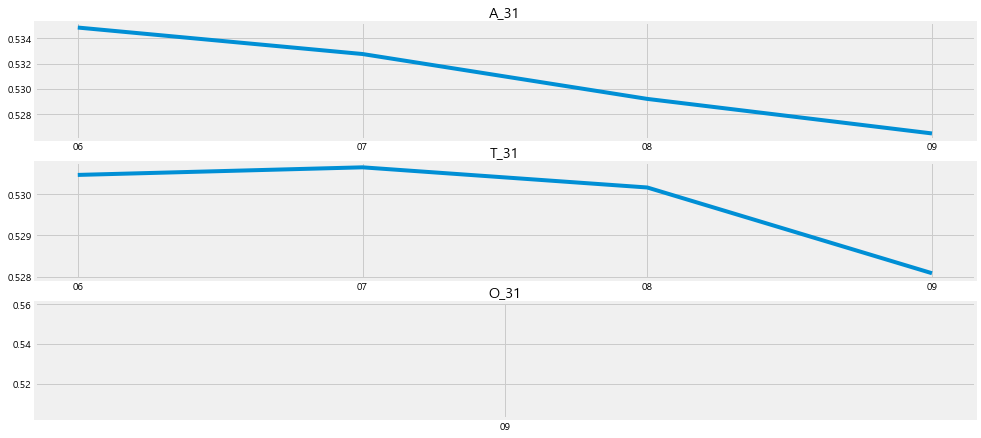

In [76]:
# PRODUCT_CODE
rcParams['figure.figsize'] = 15, 15

for i, l in enumerate(train['PRODUCT_CODE'].unique()):
    plt.subplot(len(train.LINE.unique()), 1, i+1)
    tmp = train[train['PRODUCT_CODE']==l]
    tmp['TIMESTAMP'] = pd.to_datetime(tmp['TIMESTAMP']).dt.strftime('%m')
    tmp = tmp.groupby('TIMESTAMP').mean()
    plt.plot(tmp.index, tmp['Y_Quality'])
    plt.title(l)
plt.show()

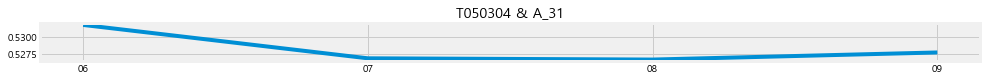

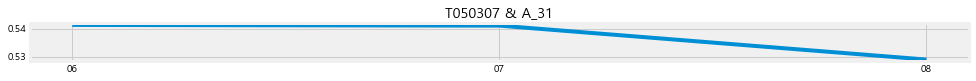

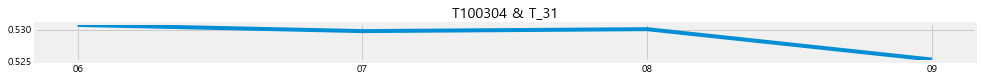

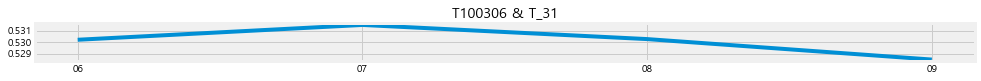

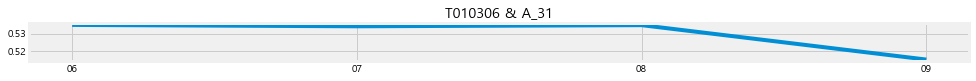

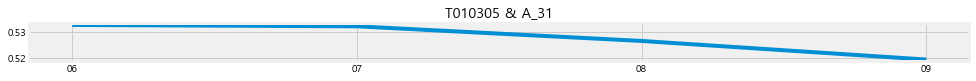

In [77]:
# LINE & PRODUCT_CODE
rcParams['figure.figsize'] = 15, 15

for i, l in enumerate(train.LINE.unique()):
    for i, c in enumerate(['A_31', 'T_31']): # O_31은 표본이 너무 적어 제외
        tmp = train[(train['PRODUCT_CODE']==c)&(train['LINE']==l)]
        if len(tmp) == 0: continue
        plt.subplot(len(train.LINE.unique())*len(train.PRODUCT_CODE.unique()), 1, i+1)
        tmp['TIMESTAMP'] = pd.to_datetime(tmp['TIMESTAMP']).dt.strftime('%m')
        tmp = tmp.groupby('TIMESTAMP').mean()
        plt.plot(tmp.index, tmp['Y_Quality'])
        plt.title(f'{l} & {c}')
    plt.show()

In [78]:
# 월별 영향력이 있어보인다.
train['TIMESTAMP'] = pd.to_datetime(train['TIMESTAMP']).dt.strftime('%m')
train['TIMESTAMP'] = train['TIMESTAMP'].astype('int64')
train.head()

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,6,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,6,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,6,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,6,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,6,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN


### X_1 ~ X_2875

In [79]:
len(train.columns)

2881

#### Product Code & Line에 따라 분류했을 경우

In [80]:
train_A1 = train[(train['PRODUCT_CODE'] == 'A_31') & (train['LINE'] == 'T050304')]
train_A2 = train[(train['PRODUCT_CODE'] == 'A_31') & (train['LINE'] == 'T050307')]
train_A3 = train[(train['PRODUCT_CODE'] == 'A_31') & (train['LINE'] == 'T010306')]
train_A4 = train[(train['PRODUCT_CODE'] == 'A_31') & (train['LINE'] == 'T010305')]
train_T1 = train[(train['PRODUCT_CODE'] == 'T_31') & (train['LINE'] == 'T100304')]
train_T2 = train[(train['PRODUCT_CODE'] == 'T_31') & (train['LINE'] == 'T100306')]
train_O1 = train[train['PRODUCT_CODE'] == 'O_31']

In [81]:
print(len(train_A1))
print(len(train_A2))
print(len(train_A3))
print(len(train_A4))
print(len(train_T1))
print(len(train_T2))
print(len(train_O1))

78
42
70
59
172
171
6


In [82]:
def remove_col(df):
    for x in df.columns[6:]:
        if len(df[df[x].isnull()]) > len(df)*0.1:
            df.drop(columns=[x], inplace=True)
    return df

In [83]:
train_A1 = remove_col(train_A1)
train_A2 = remove_col(train_A2)
train_A3 = remove_col(train_A3)
train_A4 = remove_col(train_A4)
train_T1 = remove_col(train_T1)
train_T2 = remove_col(train_T2)
train_O1 = remove_col(train_O1)

In [84]:
print(len(train_A1.columns))
print(len(train_A2.columns))
print(len(train_A3.columns))
print(len(train_A4.columns))
print(len(train_T1.columns))
print(len(train_T2.columns))
print(len(train_O1.columns))

1449
1461
877
877
662
662
656


In [85]:
# 결측값 대체
def nan_replace(df):
    for x in df.columns[6:]:
        for i in df[df[x].isnull()].index:
            m = np.mean(df[(df['Y_Class']==df['Y_Class'][i]) & (df['LINE']==df['LINE'][i]) & (df['TIMESTAMP']==df['TIMESTAMP'][i])][x])
            if str(m) != 'nan':
                df[x][i] = m
                continue
            m = np.mean(df[(df['Y_Class']==df['Y_Class'][i]) & (df['LINE']==df['LINE'][i]) & (df['TIMESTAMP']==(df['TIMESTAMP'][i]-1))][x])
            if str(m) != 'nan':
                df[x][i] = m
                continue
            m = np.mean(df[(df['Y_Class']==df['Y_Class'][i]) & (df['LINE']==df['LINE'][i]) & (df['TIMESTAMP']==(df['TIMESTAMP'][i]+1))][x])
            if str(m) != 'nan':
                df[x][i] = m
                continue
            m = np.mean(df[(df['Y_Class']==df['Y_Class'][i]) & (df['LINE']==df['LINE'][i])][x])
            if str(m) != 'nan':
                df[x][i] = m
                continue

            df[x][i] = np.mean(df[df['Y_Class']==df['Y_Class'][i]][x])
    return df

In [86]:
train_A1 = nan_replace(train_A1)
train_A2 = nan_replace(train_A2)
train_A3 = nan_replace(train_A3)
train_A4 = nan_replace(train_A4)
train_T1 = nan_replace(train_T1)
train_T2 = nan_replace(train_T2)
train_O1 = nan_replace(train_O1)

In [87]:
train_A1.reset_index(drop=True, inplace=True)
train_A2.reset_index(drop=True, inplace=True)
train_A3.reset_index(drop=True, inplace=True)
train_A4.reset_index(drop=True, inplace=True)
train_T1.reset_index(drop=True, inplace=True)
train_T2.reset_index(drop=True, inplace=True)
train_O1.reset_index(drop=True, inplace=True)

### data split & astype

In [88]:
train_A1.drop(columns=['PRODUCT_ID'], inplace=True)
train_A2.drop(columns=['PRODUCT_ID'], inplace=True)
train_A3.drop(columns=['PRODUCT_ID'], inplace=True)
train_A4.drop(columns=['PRODUCT_ID'], inplace=True)
train_T1.drop(columns=['PRODUCT_ID'], inplace=True)
train_T2.drop(columns=['PRODUCT_ID'], inplace=True)
train_O1.drop(columns=['PRODUCT_ID'], inplace=True)

In [89]:
test = test[test.columns[1:]]

test['TIMESTAMP'] = pd.to_datetime(test['TIMESTAMP']).dt.strftime('%m').astype('int64')
test['LINE'] = test['LINE'].astype('category')
test['PRODUCT_CODE'] = test['PRODUCT_CODE'].astype('category')

test.head()

,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,9,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,51.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,T010305,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Optuna

In [92]:
kfold = StratifiedKFold(n_splits=5, shuffle=True)

def lgbm_objective(trial):

    params = {
            "objective": "regression",
            "n_jobs": 4,
            "max_depth": trial.suggest_int("max_depth", 4, 512),
            'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1, log=True), 
            "learning_rate": trial.suggest_uniform('learning_rate', 0.0001, 0.99),
            'n_estimators': trial.suggest_int("n_estimators", 100, 3000, step=100),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
            "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1),
            "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1), 
            'min_child_weight': trial.suggest_int('min_child_weight', 2, 15),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        }

    reg = lightgbm.LGBMRegressor(**params)
    
    f1_list = []
    for fold, (train_index, val_index) in enumerate(kfold.split(x_train, y_class)):
        x_trn, x_val, y_trn, y_val = x_train.loc[train_index], x_train.loc[val_index], y_quality.loc[train_index], y_quality.loc[val_index]
        y_cls_val = y_class.loc[val_index]
        reg.fit(x_trn, y_trn)
        pred_quality = reg.predict(x_val)
        
        pred_class = []
        for q in pred_quality:
            if q >= 0.5349: pred_class.append(2)
            elif q <= 0.525075: pred_class.append(0)
            else: pred_class.append(1)

        f1_list.append(f1_score(pred_class, y_cls_val, average='micro'))    
    
    return np.mean(f1_list)

In [93]:
study_list = []
code_line = [['A_31', 'T100304'], ['A_31', 'T050307'], ['A_31', 'T010306'], ['A_31', 'T010305'], ['T_31', 'T100304'], ['T_31', 'T100306']]

for cl, train_df in zip(code_line, [train_A1, train_A2, train_A3, train_A4, train_T1, train_T2]):
    # split
    x_train = train_df.drop(columns=['Y_Class', 'Y_Quality'])
    y_class = train_df['Y_Class']
    y_quality = train_df['Y_Quality']

#     stdscaler = StandardScaler().fit(x_train[x_train.columns[3:]])
#     x_train[x_train.columns[3:]] = stdscaler.transform(x_train[x_train.columns[3:]])
    
    # optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(lgbm_objective, n_trials=200, show_progress_bar=True)

    clear_output(wait=True)
    study_list.append(study)

[I 2023-02-04 22:38:17,627] A new study created in memory with name: no-name-0575126c-6433-443d-b853-92d618fe98a3


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2023-02-04 22:38:17,792] Trial 0 finished with value: 0.8421848739495799 and parameters: {'max_depth': 504, 'num_leaves': 16, 'learning_rate': 0.576778281282827, 'n_estimators': 2100, 'colsample_bytree': 0.6553098090617446, 'colsample_bynode': 0.9885479826752132, 'reg_lambda': 0.948164454823287, 'reg_alpha': 0.08005304654619509, 'min_child_weight': 15, 'min_child_samples': 85}. Best is trial 0 with value: 0.8421848739495799.
[I 2023-02-04 22:38:17,942] Trial 1 finished with value: 0.8421848739495799 and parameters: {'max_depth': 441, 'num_leaves': 43, 'learning_rate': 0.7915573289436528, 'n_estimators': 2000, 'colsample_bytree': 0.7214754139812605, 'colsample_bynode': 0.5107524164905449, 'reg_lambda': 0.5875642110900025, 'reg_alpha': 0.033709068744678404, 'min_child_weight': 6, 'min_child_samples': 76}. Best is trial 0 with value: 0.8421848739495799.
[I 2023-02-04 22:38:18,294] Trial 2 finished with value: 0.8421848739495799 and parameters: {'max_depth': 486, 'num_leaves': 357, 'lea

[I 2023-02-04 22:38:25,941] Trial 19 finished with value: 0.7892436974789916 and parameters: {'max_depth': 508, 'num_leaves': 17, 'learning_rate': 0.9468334785454181, 'n_estimators': 2700, 'colsample_bytree': 0.8833852666710584, 'colsample_bynode': 0.8395076815236691, 'reg_lambda': 0.3076694653731815, 'reg_alpha': 0.023408037085115397, 'min_child_weight': 4, 'min_child_samples': 28}. Best is trial 0 with value: 0.8421848739495799.
[I 2023-02-04 22:38:26,081] Trial 20 finished with value: 0.8421848739495799 and parameters: {'max_depth': 175, 'num_leaves': 2, 'learning_rate': 0.7032769867279728, 'n_estimators': 1700, 'colsample_bytree': 0.7606913522047037, 'colsample_bynode': 0.7341596372040377, 'reg_lambda': 0.5798520916525757, 'reg_alpha': 0.06629363506162048, 'min_child_weight': 11, 'min_child_samples': 88}. Best is trial 0 with value: 0.8421848739495799.
[I 2023-02-04 22:38:26,198] Trial 21 finished with value: 0.8421848739495799 and parameters: {'max_depth': 325, 'num_leaves': 3, 'l

[I 2023-02-04 22:38:32,601] Trial 38 finished with value: 0.8421848739495799 and parameters: {'max_depth': 307, 'num_leaves': 3, 'learning_rate': 0.10125094966194144, 'n_estimators': 900, 'colsample_bytree': 0.704090105143435, 'colsample_bynode': 0.9732802881905774, 'reg_lambda': 0.11966662438559758, 'reg_alpha': 0.40722477971632665, 'min_child_weight': 9, 'min_child_samples': 14}. Best is trial 0 with value: 0.8421848739495799.
[I 2023-02-04 22:38:32,854] Trial 39 finished with value: 0.8421848739495799 and parameters: {'max_depth': 230, 'num_leaves': 5, 'learning_rate': 0.22282037152918124, 'n_estimators': 400, 'colsample_bytree': 0.7321006454891067, 'colsample_bynode': 0.8040242541390056, 'reg_lambda': 0.2352791821563148, 'reg_alpha': 0.7078813943831049, 'min_child_weight': 11, 'min_child_samples': 28}. Best is trial 0 with value: 0.8421848739495799.
[I 2023-02-04 22:38:33,895] Trial 40 finished with value: 0.8421848739495799 and parameters: {'max_depth': 446, 'num_leaves': 999, 'le

[I 2023-02-04 22:38:40,415] Trial 57 finished with value: 0.8421848739495799 and parameters: {'max_depth': 31, 'num_leaves': 34, 'learning_rate': 0.7571049070088058, 'n_estimators': 2000, 'colsample_bytree': 0.5556598955555061, 'colsample_bynode': 0.8784223863271733, 'reg_lambda': 0.012853479238191181, 'reg_alpha': 0.18338553047338663, 'min_child_weight': 7, 'min_child_samples': 52}. Best is trial 0 with value: 0.8421848739495799.
[I 2023-02-04 22:38:41,004] Trial 58 finished with value: 0.8421848739495799 and parameters: {'max_depth': 62, 'num_leaves': 43, 'learning_rate': 0.5413573453974395, 'n_estimators': 1900, 'colsample_bytree': 0.5618755684328388, 'colsample_bynode': 0.9243581247710139, 'reg_lambda': 0.016015131889263953, 'reg_alpha': 0.048068719785377745, 'min_child_weight': 14, 'min_child_samples': 57}. Best is trial 0 with value: 0.8421848739495799.
[I 2023-02-04 22:38:41,782] Trial 59 finished with value: 0.8421848739495799 and parameters: {'max_depth': 5, 'num_leaves': 54, 

[I 2023-02-04 22:38:47,127] Trial 76 finished with value: 0.8421848739495799 and parameters: {'max_depth': 95, 'num_leaves': 144, 'learning_rate': 0.34292028484074377, 'n_estimators': 1800, 'colsample_bytree': 0.5149717250818318, 'colsample_bynode': 0.9127127417269465, 'reg_lambda': 0.011590759267530601, 'reg_alpha': 0.13710977789991122, 'min_child_weight': 15, 'min_child_samples': 60}. Best is trial 0 with value: 0.8421848739495799.
[I 2023-02-04 22:38:47,348] Trial 77 finished with value: 0.8421848739495799 and parameters: {'max_depth': 58, 'num_leaves': 98, 'learning_rate': 0.4723712324269823, 'n_estimators': 500, 'colsample_bytree': 0.5451700323182564, 'colsample_bynode': 0.9542325044717859, 'reg_lambda': 0.018592375351398717, 'reg_alpha': 0.14412918995310597, 'min_child_weight': 15, 'min_child_samples': 63}. Best is trial 0 with value: 0.8421848739495799.
[I 2023-02-04 22:38:47,539] Trial 78 finished with value: 0.8421848739495799 and parameters: {'max_depth': 83, 'num_leaves': 34

[I 2023-02-04 22:38:58,399] Trial 95 finished with value: 0.8421848739495799 and parameters: {'max_depth': 227, 'num_leaves': 20, 'learning_rate': 0.8240683993752774, 'n_estimators': 800, 'colsample_bytree': 0.7605613179526163, 'colsample_bynode': 0.5540902862164846, 'reg_lambda': 0.1616452232499436, 'reg_alpha': 0.8183796323323124, 'min_child_weight': 11, 'min_child_samples': 40}. Best is trial 0 with value: 0.8421848739495799.
[I 2023-02-04 22:38:58,842] Trial 96 finished with value: 0.8421848739495799 and parameters: {'max_depth': 303, 'num_leaves': 20, 'learning_rate': 0.690345100895733, 'n_estimators': 1000, 'colsample_bytree': 0.7016158854971959, 'colsample_bynode': 0.6873600937867811, 'reg_lambda': 0.5244707390686345, 'reg_alpha': 0.415410879481381, 'min_child_weight': 11, 'min_child_samples': 37}. Best is trial 0 with value: 0.8421848739495799.
[I 2023-02-04 22:38:59,213] Trial 97 finished with value: 0.8421848739495799 and parameters: {'max_depth': 481, 'num_leaves': 2, 'learn

[I 2023-02-04 22:39:04,315] Trial 115 finished with value: 0.8421848739495796 and parameters: {'max_depth': 62, 'num_leaves': 295, 'learning_rate': 0.41751316631958435, 'n_estimators': 200, 'colsample_bytree': 0.5130329574629774, 'colsample_bynode': 0.9142610185393629, 'reg_lambda': 0.0212410939903795, 'reg_alpha': 0.02105162152520063, 'min_child_weight': 14, 'min_child_samples': 66}. Best is trial 0 with value: 0.8421848739495799.
[I 2023-02-04 22:39:04,498] Trial 116 finished with value: 0.8421848739495799 and parameters: {'max_depth': 38, 'num_leaves': 137, 'learning_rate': 0.4832327270808296, 'n_estimators': 2600, 'colsample_bytree': 0.8917787675786402, 'colsample_bynode': 0.9364596686218348, 'reg_lambda': 0.012107469654999486, 'reg_alpha': 0.09660978756163659, 'min_child_weight': 6, 'min_child_samples': 77}. Best is trial 0 with value: 0.8421848739495799.
[I 2023-02-04 22:39:05,234] Trial 117 finished with value: 0.8421848739495799 and parameters: {'max_depth': 30, 'num_leaves': 6

[I 2023-02-04 22:39:18,152] Trial 134 finished with value: 0.8421848739495799 and parameters: {'max_depth': 332, 'num_leaves': 33, 'learning_rate': 0.8553329701518331, 'n_estimators': 2900, 'colsample_bytree': 0.729608146931821, 'colsample_bynode': 0.5161701112336763, 'reg_lambda': 0.4737675282142672, 'reg_alpha': 0.5220188553403169, 'min_child_weight': 11, 'min_child_samples': 38}. Best is trial 124 with value: 0.8480672268907563.
[I 2023-02-04 22:39:18,814] Trial 135 finished with value: 0.8421848739495799 and parameters: {'max_depth': 317, 'num_leaves': 1021, 'learning_rate': 0.9363742582192364, 'n_estimators': 1000, 'colsample_bytree': 0.7382742438003633, 'colsample_bynode': 0.6829460809700654, 'reg_lambda': 0.18322810477832932, 'reg_alpha': 0.265327684543934, 'min_child_weight': 11, 'min_child_samples': 35}. Best is trial 124 with value: 0.8480672268907563.
[I 2023-02-04 22:39:19,256] Trial 136 finished with value: 0.8421848739495799 and parameters: {'max_depth': 395, 'num_leaves'

[I 2023-02-04 22:39:27,129] Trial 153 finished with value: 0.8421848739495799 and parameters: {'max_depth': 486, 'num_leaves': 13, 'learning_rate': 0.15089174185136034, 'n_estimators': 300, 'colsample_bytree': 0.6450966166075228, 'colsample_bynode': 0.7779794653453196, 'reg_lambda': 0.1265650690505421, 'reg_alpha': 0.07056193704757455, 'min_child_weight': 6, 'min_child_samples': 12}. Best is trial 124 with value: 0.8480672268907563.
[I 2023-02-04 22:39:27,235] Trial 154 finished with value: 0.8421848739495799 and parameters: {'max_depth': 493, 'num_leaves': 26, 'learning_rate': 0.03993051584712631, 'n_estimators': 400, 'colsample_bytree': 0.616509386064971, 'colsample_bynode': 0.816630305333227, 'reg_lambda': 0.06945738802174142, 'reg_alpha': 0.06079586413227159, 'min_child_weight': 7, 'min_child_samples': 100}. Best is trial 124 with value: 0.8480672268907563.
[I 2023-02-04 22:39:27,340] Trial 155 finished with value: 0.8421848739495799 and parameters: {'max_depth': 181, 'num_leaves':

[I 2023-02-04 22:39:30,908] Trial 173 finished with value: 0.8421848739495799 and parameters: {'max_depth': 21, 'num_leaves': 308, 'learning_rate': 0.5423533667496975, 'n_estimators': 2700, 'colsample_bytree': 0.573441271882383, 'colsample_bynode': 0.8587247921081121, 'reg_lambda': 0.014105482822593867, 'reg_alpha': 0.20956499366196504, 'min_child_weight': 15, 'min_child_samples': 61}. Best is trial 124 with value: 0.8480672268907563.
[I 2023-02-04 22:39:31,114] Trial 174 finished with value: 0.8421848739495799 and parameters: {'max_depth': 44, 'num_leaves': 175, 'learning_rate': 0.6777036319300997, 'n_estimators': 2900, 'colsample_bytree': 0.9240052042250704, 'colsample_bynode': 0.9326423918410656, 'reg_lambda': 0.010513833128606213, 'reg_alpha': 0.02837414428907175, 'min_child_weight': 4, 'min_child_samples': 78}. Best is trial 124 with value: 0.8480672268907563.
[I 2023-02-04 22:39:32,153] Trial 175 finished with value: 0.8363025210084034 and parameters: {'max_depth': 34, 'num_leave

[I 2023-02-04 22:39:45,159] Trial 192 finished with value: 0.8421848739495799 and parameters: {'max_depth': 466, 'num_leaves': 586, 'learning_rate': 0.9507441086763605, 'n_estimators': 1000, 'colsample_bytree': 0.7648518096578999, 'colsample_bynode': 0.5987600993005288, 'reg_lambda': 0.5320153437623085, 'reg_alpha': 0.4075910601344149, 'min_child_weight': 11, 'min_child_samples': 54}. Best is trial 124 with value: 0.8480672268907563.
[I 2023-02-04 22:39:45,769] Trial 193 finished with value: 0.8421848739495799 and parameters: {'max_depth': 334, 'num_leaves': 975, 'learning_rate': 0.8706898438253912, 'n_estimators': 1000, 'colsample_bytree': 0.7133967694130985, 'colsample_bynode': 0.6165026346813757, 'reg_lambda': 0.5942381415947128, 'reg_alpha': 0.473452076714278, 'min_child_weight': 11, 'min_child_samples': 46}. Best is trial 124 with value: 0.8480672268907563.
[I 2023-02-04 22:39:46,313] Trial 194 finished with value: 0.8421848739495799 and parameters: {'max_depth': 296, 'num_leaves'

In [94]:
def lgbm_objective_O_31(trial):

    params = {
            "objective": "regression",
            "n_jobs": 4,
            "max_depth": trial.suggest_int("max_depth", 4, 512),
            'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1, log=True), 
            "learning_rate": trial.suggest_uniform('learning_rate', 0.0001, 0.99),
            'n_estimators': trial.suggest_int("n_estimators", 100, 3000, step=100),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
            "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1),
            "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1), 
            'min_child_weight': trial.suggest_int('min_child_weight', 2, 15),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        }

    reg = lightgbm.LGBMRegressor(**params)
    reg.fit(x_train, y_quality)
    pred_quality = reg.predict(x_train)

    pred_class = []
    for q in pred_quality:
        if q >= 0.5349: pred_class.append(2)
        elif q <= 0.525075: pred_class.append(0)
        else: pred_class.append(1)

    return f1_score(pred_class, y_class, average='micro')

x_train = train_O1.drop(columns=['Y_Class', 'Y_Quality'])
y_class = train_O1['Y_Class']
y_quality = train_O1['Y_Quality']

# stdscaler = StandardScaler().fit(x_train[x_train.columns[3:]])
# x_train[x_train.columns[3:]] = stdscaler.transform(x_train[x_train.columns[3:]])

study = optuna.create_study(direction='maximize')
study.optimize(lgbm_objective_O_31, n_trials=50, show_progress_bar=True)

clear_output(wait=True)
study_list.append(study)

[I 2023-02-04 22:39:50,586] A new study created in memory with name: no-name-a203ccb6-c1d2-491a-9161-0baba7ebc57d


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-02-04 22:39:50,640] Trial 0 finished with value: 0.6666666666666666 and parameters: {'max_depth': 456, 'num_leaves': 2, 'learning_rate': 0.9154807512341436, 'n_estimators': 1800, 'colsample_bytree': 0.9297690716648455, 'colsample_bynode': 0.627159493204221, 'reg_lambda': 0.07898526607097386, 'reg_alpha': 0.037238279201186095, 'min_child_weight': 5, 'min_child_samples': 49}. Best is trial 0 with value: 0.6666666666666666.
[I 2023-02-04 22:39:50,671] Trial 1 finished with value: 0.6666666666666666 and parameters: {'max_depth': 326, 'num_leaves': 52, 'learning_rate': 0.6095716904606273, 'n_estimators': 800, 'colsample_bytree': 0.6592323921368524, 'colsample_bynode': 0.5985865768398595, 'reg_lambda': 0.7985848870580277, 'reg_alpha': 0.552203196259856, 'min_child_weight': 12, 'min_child_samples': 32}. Best is trial 0 with value: 0.6666666666666666.
[I 2023-02-04 22:39:50,732] Trial 2 finished with value: 0.6666666666666666 and parameters: {'max_depth': 255, 'num_leaves': 403, 'learn

[I 2023-02-04 22:39:51,614] Trial 22 finished with value: 0.6666666666666666 and parameters: {'max_depth': 252, 'num_leaves': 175, 'learning_rate': 0.4771244383469413, 'n_estimators': 3000, 'colsample_bytree': 0.9548331647037835, 'colsample_bynode': 0.752530417692396, 'reg_lambda': 0.05181348023700132, 'reg_alpha': 0.045851710902262754, 'min_child_weight': 3, 'min_child_samples': 61}. Best is trial 0 with value: 0.6666666666666666.
[I 2023-02-04 22:39:51,657] Trial 23 finished with value: 0.6666666666666666 and parameters: {'max_depth': 23, 'num_leaves': 5, 'learning_rate': 0.8743601851911692, 'n_estimators': 1600, 'colsample_bytree': 0.80360395482049, 'colsample_bynode': 0.7284493212199528, 'reg_lambda': 0.06657349772698297, 'reg_alpha': 0.020726214318223052, 'min_child_weight': 7, 'min_child_samples': 56}. Best is trial 0 with value: 0.6666666666666666.
[I 2023-02-04 22:39:51,710] Trial 24 finished with value: 0.6666666666666666 and parameters: {'max_depth': 116, 'num_leaves': 4, 'le

[I 2023-02-04 22:39:52,786] Trial 45 finished with value: 0.6666666666666666 and parameters: {'max_depth': 109, 'num_leaves': 3, 'learning_rate': 0.001415922055069789, 'n_estimators': 2200, 'colsample_bytree': 0.9380630855937934, 'colsample_bynode': 0.5039863852438827, 'reg_lambda': 0.03133400560218227, 'reg_alpha': 0.09031779113540886, 'min_child_weight': 4, 'min_child_samples': 80}. Best is trial 0 with value: 0.6666666666666666.
[I 2023-02-04 22:39:52,842] Trial 46 finished with value: 0.6666666666666666 and parameters: {'max_depth': 183, 'num_leaves': 13, 'learning_rate': 0.03971761743306268, 'n_estimators': 2700, 'colsample_bytree': 0.9743121607581188, 'colsample_bynode': 0.9562139524741684, 'reg_lambda': 0.02669581953073014, 'reg_alpha': 0.027556340331637952, 'min_child_weight': 9, 'min_child_samples': 69}. Best is trial 0 with value: 0.6666666666666666.
[I 2023-02-04 22:39:52,889] Trial 47 finished with value: 0.6666666666666666 and parameters: {'max_depth': 477, 'num_leaves': 2

In [59]:
print()
f1_list = []

for study in study_list:
    trial = study.best_trial

    print("  f1_score : {}".format(trial.value))
    f1_list.append(trial.value)

print()
print(f'mean_f1 : {np.mean(f1_list)}')


  f1_score : 0.7566666666666667
  f1_score : 0.8555555555555555
  f1_score : 0.8
  f1_score : 0.6454545454545455
  f1_score : 0.8722689075630251
  f1_score : 0.8596638655462184
  f1_score : 0.6666666666666666

mean_f1 : 0.7794680296360968


In [60]:
for study in study_list:
    print(study.best_params)
    print()

{'max_depth': 143, 'num_leaves': 84, 'learning_rate': 0.0593287744995169, 'n_estimators': 3000, 'colsample_bytree': 0.6481473556737528, 'colsample_bynode': 0.5587356166512139, 'reg_lambda': 0.20373038320236878, 'reg_alpha': 0.01424349521096161, 'min_child_weight': 2, 'min_child_samples': 5}

{'max_depth': 16, 'num_leaves': 3, 'learning_rate': 0.5340420859870473, 'n_estimators': 700, 'colsample_bytree': 0.6308032467020607, 'colsample_bynode': 0.7006358511688878, 'reg_lambda': 0.17203495570584879, 'reg_alpha': 0.038017872176906456, 'min_child_weight': 5, 'min_child_samples': 13}

{'max_depth': 306, 'num_leaves': 305, 'learning_rate': 0.42645618678025043, 'n_estimators': 1900, 'colsample_bytree': 0.9181662919245883, 'colsample_bynode': 0.5008708707529731, 'reg_lambda': 0.02407246846100114, 'reg_alpha': 0.011840160191549544, 'min_child_weight': 15, 'min_child_samples': 18}

{'max_depth': 38, 'num_leaves': 326, 'learning_rate': 0.8579397128596566, 'n_estimators': 1900, 'colsample_bytree': 0

In [61]:
code_line += ['O_31']
for cl, train_df, study in zip(code_line, [train_A1, train_A2, train_A3, train_A4, train_T1, train_T2, train_O1], study_list):

    x_train = train_df.drop(columns=['Y_Class', 'Y_Quality'])
    y_class = train_df['Y_Class']
    y_quality = train_df['Y_Quality']
    
    if cl[0] == 'O_31': test_cl = test[test['PRODUCT_CODE'] == cl[0]]
    else: test_cl = test[(test['PRODUCT_CODE'] == cl[0]) & (test['LINE'] == cl[1])]

    if len(test_cl) == 0: continue
    test_cl = test_cl[x_train.columns]
    
#     stdscaler = StandardScaler().fit(x_train[x_train.columns[3:]])
#     x_train[x_train.columns[3:]] = stdscaler.transform(x_train[x_train.columns[3:]])
#     test_cl[test_cl.columns[3:]] = stdscaler.transform(test_cl[test_cl.columns[3:]])
    
    # lightgbm
    reg = lightgbm.LGBMRegressor(**study.best_params)
    reg.fit(x_train, y_quality, verbose=0)
    pred_quality = reg.predict(test_cl)
    
    pred_class = []
    for q in pred_quality:
        if q >= 0.5349: pred_class.append(2)
        elif q <= 0.525075: pred_class.append(0)
        else: pred_class.append(1)
    
    for i, idx in enumerate(test_cl.index):
        subm['Y_Class'][idx] = pred_class[i]

In [62]:
subm.Y_Class.value_counts()

1    274
0     31
2      5
Name: Y_Class, dtype: int64

In [63]:
#subm.to_csv('submission/submission13.csv', index=False) # optuna200_lgbmr_micro_cl_devision_yquality